<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Ali Salesi
### Student Number : 99105334
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081),
])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size=2000, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=2000, shuffle=False)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer_1 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU(),
        )
        self.layer_2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(16, 64, 3, 1, 1),
            nn.ReLU(),
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
        )
        self.layer_4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10),
        )
    def forward(self, x):
        x = self.base(x)
        out = self.layer_1(x)
        x = self.layer_2(out + x)
        out = self.layer_3(x)
        return self.layer_4(out + x)

# Train Model (30 Points)

In [7]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0035)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=35)

In [8]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 35

tl = dict()
ta = dict()
vl = dict()
va = dict()
best_valid_acc = 0

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    model.train()
    train_loss = 0
    valid_loss = 0
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0
    for images, labels in train_loader:  
        inputs, targets = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        pbar.set_description(f'ACC: {train_correct / train_total:.03f} | LOSS: {train_loss / train_total:.03f}')

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            inputs, targets = images.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_total += targets.size(0)
            valid_correct += predicted.eq(targets).sum().item()
            pbar.set_postfix_str(f'ACC: {valid_correct / valid_total:.03f} | LOSS: {valid_loss / valid_total:.03f}')
    scheduler.step()
    
    tl[epoch] = train_loss / train_total
    ta[epoch] = 100.0 * train_correct / train_total
    vl[epoch] = valid_loss / valid_total
    va[epoch] = 100.0 * valid_correct / valid_total
    if va[epoch] > best_valid_acc:
        best_valid_acc = va[epoch]
        torch.save(model.state_dict(), 'best_rnet.pts')

ACC: 0.988 | LOSS: 0.000: 100%|██████████████████████████████| 35/35 [05:31<00:00,  9.46s/it, ACC: 0.983 | LOSS: 0.000]


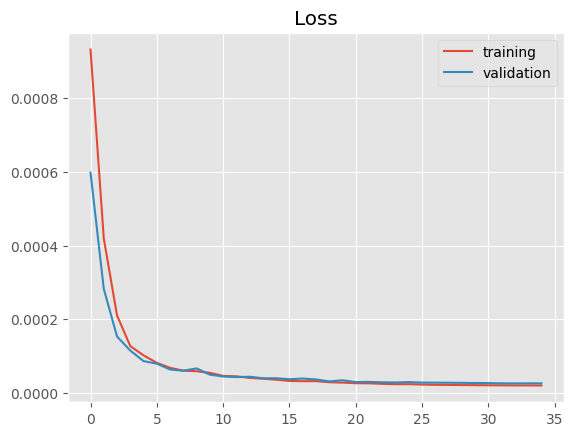

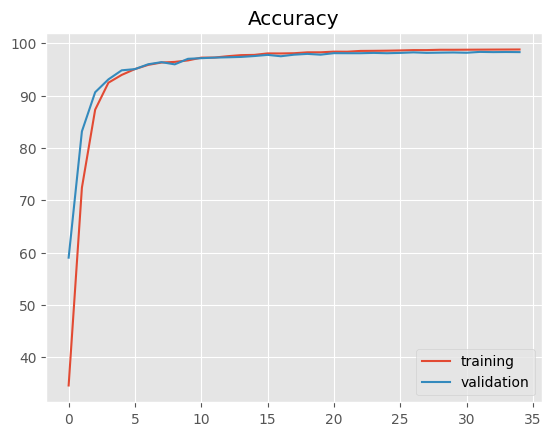

In [9]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(*zip(*sorted(tl.items())), label='training')
plt.plot(*zip(*sorted(vl.items())), label='validation')
plt.title('Loss')
plt.legend()
plt.show()
plt.plot(*zip(*sorted(ta.items())), label='training')
plt.plot(*zip(*sorted(va.items())), label='validation')
plt.title('Accuracy')
plt.legend()
plt.show()

# Test Model (20 Points)

In [10]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

model.load_state_dict(torch.load('best_rnet.pts'))
model.eval()
valid_loss = 0
valid_correct = 0
valid_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        inputs, targets = images.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        valid_loss += loss.item()
        _, predicted = outputs.max(1)
        valid_total += targets.size(0)
        valid_correct += predicted.eq(targets).sum().item()
print(f'ACC: {train_correct / train_total:.03f} | LOSS: {train_loss / train_total:.03f}')

10000
ACC: 0.988 | LOSS: 0.000
